# Sleep

> Functions to predict sleep 

In [2]:
#| default_exp sleep

In [3]:
#| export
from nbdev import show_doc

In [4]:
#| export

import numpy as np
import pandas as pd
import scipy as sp
from numba import jit
from scipy import interpolate
import torch 
import json
import pytz
import datetime
import copy
import scipy as sp
from scipy.integrate import solve_ivp
from math import *
import pylab as plt

from circadian.utils import *
from scipy.optimize import minimize

In [44]:
#| export

class TwoProcessModel:

    def __init__(self, 
                 timetotal: np.ndarray,
                 R: np.ndarray, 
                 Psi: np.ndarray, 
                 steps: np.ndarray):

        self.StepsFunc = lambda t: np.interp(t, timetotal, steps)
        self.PhaseFunc = lambda t:  np.interp(t, timetotal, Psi)
        self.AmplitudeFunc =  lambda t: np.interp(t, timetotal, R)
        self.steps = steps
        self.timetotal = timetotal
        self.steps_wake_threshold = 10.0
        self.awake = True

    @staticmethod
    def check_wake_status(awake: bool, # current wake status
                          h: float,  # homeostat value
                          psi: float #circadian phase
                          ) -> bool:

        c = np.cos(psi)
        H_minus = 0.17
        H_plus = 0.6
        homeostat_a = 0.10

        upper = (H_plus + homeostat_a * c)
        lower = (H_minus + homeostat_a * c)
        above_threshold = h > upper
        below_threshold = h <= lower

        if above_threshold:
            return False
        elif below_threshold:
            return True
        else:
            return awake

    def dhomeostat(self, 
                   t: float, # time in hours
                   u: float # homeostat value
                   ) -> float:

        h = u[0]
        # Two Process Params
        tau_s = 4.2  # hours
        tau_w = 18.2  # hours
        mu_s = 1
        
        
        step_awake = (self.StepsFunc(t) > self.steps_wake_threshold) or self.awake
        dH = (mu_s - h) / tau_w if step_awake else -h / tau_s
        self.awake = TwoProcessModel.check_wake_status(
            self.awake, 
            h, 
            self.PhaseFunc(t)
            )
        return np.array([dH]) 

    def __call__(self, 
                 initial_value: float = 0.50 #  initial value for the homeostat
                 ):

        sol = solve_ivp(self.dhomeostat,
                        (self.timetotal[0], self.timetotal[-1]), 
                        [initial_value],
                        t_eval = self.timetotal, method='RK45')
        return(sol.y[0,:])

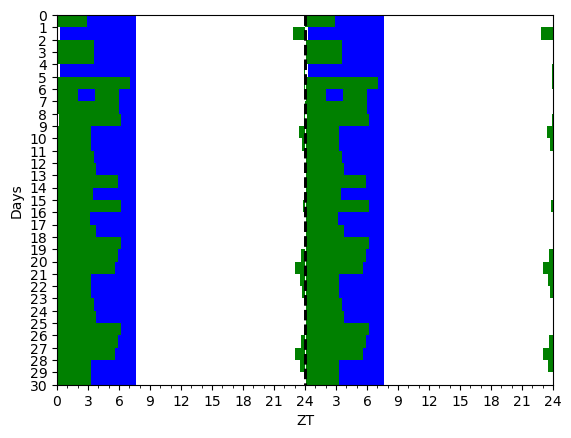

In [47]:
from circadian.models import * 
from circadian.lights import *
from circadian.plots import *

model = SinglePopModel()
ts = np.arange(0, 24*30, 0.10)
light = Light.RegularLight(lights_off=24.0)
light_est = light(ts, repeat_period=24.0) 
ic = model.default_initial_conditions()
sol = model(ts, light_est, ic)

sleep_model = TwoProcessModel(ts, sol[0,:], sol[1,:], light_est)
homeostat = sleep_model(initial_value=0.80)
# Where the homeostat is increasing, we are awake where decreasing we are asleep
wake_predicted = np.where(np.diff(homeostat,prepend=1.0) > 0.0, 1.0, 0.0)
Actogram(ts, light_vals=light_est, threshold=10.0, color='blue', alpha=0.5)
Actogram(ts, light_vals=wake_predicted, threshold=0.50, color='green', alpha=0.5);


In [7]:
#| export 


def sleep_midpoint(timetotal: np.ndarray, 
                   Wake: np.ndarray, 
                   durations=True):
    """
        Given a wearable data frame with a Wake column which takes 
        the values 0, 1, missing this routine will create a sleep phase 
        column which is based on constant phase accumulation between sleep 
        midpoints. 

        The sleep midpoints are found using the criteria than they the median 
        time where 

    """

    sleep_start = []
    sleep_end = []
    awake = Wake[0] > 0.50

    if not awake:
        sleep_start.append(timetotal[1])

    for k in range(1, len(Wake)):
        if (Wake[k] > 0.50 and not awake):
            awake = True
            sleep_end.append(timetotal[k])

        if (Wake[k] <= 0.50 and awake):
            awake = False
            sleep_start.append(timetotal[k])

    if Wake[-1] <= 0.50:
        sleep_end.append(timetotal[-1])

    assert len(sleep_start) == len(sleep_end)
    sleep_midpoints = []
    sleep_durations = []
    for (s1, s2) in zip(sleep_start, sleep_end):
        sleep_midpoints += [(s2-s1)/2+s1]
        sleep_durations += [s2-s1]

    if durations:
        return np.array(sleep_midpoints), np.array(sleep_durations)
    else:
        return np.array(sleep_midpoints)



In [8]:
#| export 


def cluster_sleep_periods_scipy(wake_data: np.ndarray, 
                                epsilon: float,
                                makeplot: bool = False,
                                max_sleep_clusters=None, 
                                min_sleep_clusters=None):
    """
        Given a binary vector wake_data which gives a prediction for the sleep/wake  
        status and a regularization penalty ε this function will create smoothed 
        sleep-wake periods. This helps as preprocessing to remove erroneous short sleep 
        periods (and wake) which may mess up calculations like the sleep midpoint for 
        the day

        cluster_sleep_periods(wake_data : np.ndarray, epsilon: float, makeplot: bool=False):
    """

    np.nan_to_num(wake_data, 0.50)

    def objective(w):
        return sum(w * (1 - wake_data)) + sum((1 - w)*wake_data) + epsilon*sum((w[1:]-w[0:-1])**2)

    max_clusters = max_sleep_clusters or len(wake_data)

    def constraint1(x):
        return max_clusters-sum((x[1:]-x[0:-1])**2)  # geq 0

    min_clusters = min_sleep_clusters or 0

    print(
        f"The max clusters are {max_clusters} and the min clusters are {min_clusters}")

    def constraint2(x):
        return sum((x[1:]-x[0:-1])**2)-min_clusters  # geq 0

    bnds = (0.0, 1.0)
    all_bnds = [bnds for b in range(len(wake_data))]

    constraint1d = {'type': 'ineq', 'fun': constraint1}
    constraint2d = {'type': 'ineq', 'fun': constraint2}
    all_cons = [constraint1d, constraint2d]

    x0 = wake_data
    sol = minimize(objective, x0, method='SLSQP', bounds=all_bnds)

    if makeplot:
        pl = plt.scatter(range(len(wake_data)), wake_data + 0.1 *
                         np.random.randn(len(wake_data)), label="", color="blue")
        plt.plot(range(len(wake_data)), convert_binary(
            sol.x), lw=2.0, label="", color="red")
        plt.show()

    print(
        f"The max clusters are {max_clusters} takes value {constraint1(sol.x)}>=0.0")
    print(
        f"The min clusters are {min_clusters} and takes the value {constraint2(sol.x)}>=0.0")
    return(convert_binary(sol.x))

In [9]:
#| hide
import nbdev; nbdev.nbdev_export()